In [1]:
# make sure to use python 3.8, use virtual environment (to make terminal also 3.8) and reopen vscode 
from gym.wrappers import GrayScaleObservation
from gym.wrappers import ResizeObservation  # these things also use cv2, pip install it (opencv-python)
from gym.wrappers import FrameStack
import gym

from nes_py.wrappers import JoypadSpace

import gym_super_mario_bros  # install the VS code Developer kit?? refer to nes_py
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# import retro # use to import sonic, #don't worry about it for now
from drpreisl_angus_tsa_DQN import DQN # our assignment 2 DQN modified for gym instead of gymnasium, may change later
import torch
import matplotlib.pyplot as plt

cpu


In [ ]:
#Prints the reward per epsisode graph (Pulled from Assignment 2)
def reward_print(reward_per_episode, episodes, info): 
    mins = int(min(reward_per_episode)) - int(min(reward_per_episode)) * (.15)
    maxs = int(max(reward_per_episode)) + int(max(reward_per_episode)) * (.3) 
    plt.figure()
    plt.plot(reward_per_episode)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Cumulative Reward', fontsize=20)
    plt.title(f'Cumulative Reward Per Episode ({info})', fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin= mins, ymax=maxs)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()

#prints the epsilon decay graph
def ep_decay(eps, episodes):
    epsilon_values = [(eps ** i) * 1 for i in range(episodes)]
    plt.figure()
    plt.plot(epsilon_values, linewidth=4)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Epsilon Value', fontsize=20)
    plt.title(f"Epsilon Decay for {eps}", fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation

class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


In [3]:
# create environment and agent + image preprocessing
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v3', apply_api_compatibility=True, render_mode="None")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# IMAGE PROCESSING HERE
# env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=(64, 64))
# env = FrameStack(env, num_stack = 4)
state, info = env.reset()
# env.render()

Buffer_Size = 5000
Mario = DQN(Buffer_Size, env)
print("Successfully Created agent")

c:\Users\corvi\Final project 2\final-project\.venv\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


Successfully Created agent


In [ ]:
# HyperParameters:
max_episodes = 500
epsilon = .9
discount = 0.99
action = Mario.action
# Run DQN here
total_rewards = Mario.train(episodes=max_episodes, epsilon=epsilon, discount=discount, action_function=action,
                            greedy=False)
Mario.save("drpreisl_angus_tsa_1-1.pickle")
print("training complete")    
reward_print(total_rewards, max_episodes, "World 1-1")
ep_decay(epsilon, max_episodes)
print("reward_list", total_rewards)

c:\Users\corvi\Final project 2\final-project\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\corvi\Final project 2\final-project\drpreisl_angus_tsa_DQN.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_batch = torch.tensor(states, dtype=torch.float32, device=device)
c:\Users\corvi\Final project 2\final-project\drpreisl_angus_tsa_DQN.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_batch = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
c:\Users\corvi\Final project 2\final-project\

In [ ]:
# Additional episodes
# Run DQN here
# new_total_rewards = Mario.train(episodes=max_episodes, epsilon=epsilon, discount=discount, action_function=action,
#                             greedy=False)

In [ ]:
# test training on 2nd env with pretrained
env = gym_super_mario_bros.make('SuperMarioBros-1-2-v3', apply_api_compatibility=True, render_mode="none",)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# IMAGE PROCESSING HERE
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=(64, 64))
state, info = env.reset()
Mario = DQN(Buffer_Size, env)
Mario.load("drpreisl_angus_tsa_1-1.pickle")
total_rewards = Mario.train(episodes=max_episodes, epsilon=epsilon, discount=discount, action_function=action,greedy=False)
Mario.save("drpreisl_angus_tsa_With_pre_1-2.pickle")
print("training complete")
reward_print(total_rewards, max_episodes, "PreTrained World 1-2")
ep_decay(epsilon, max_episodes)
print("reward_list", total_rewards)

c:\Users\corvi\Final project 2\final-project\.venv\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


KeyboardInterrupt: 

training complete


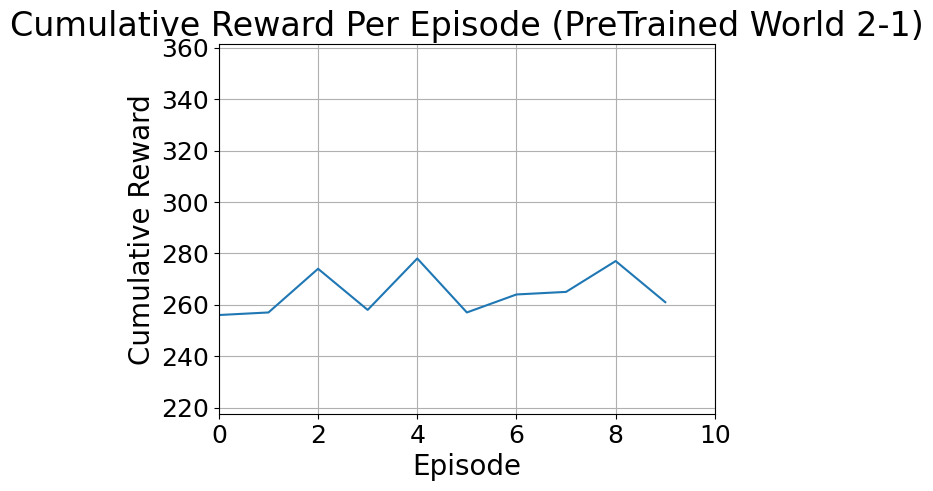

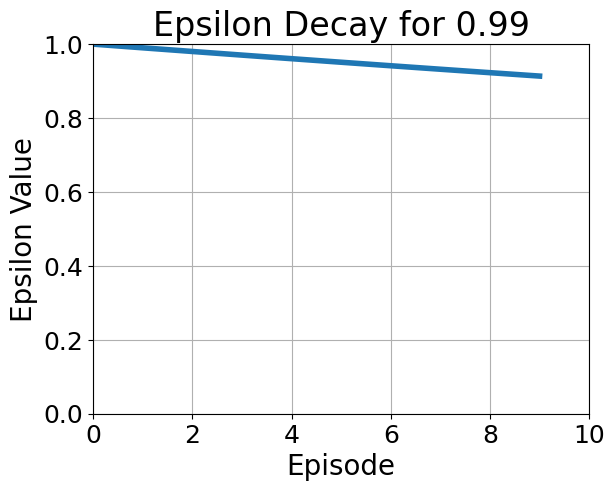

reward_list [256.0, 257.0, 274.0, 258.0, 278.0, 257.0, 264.0, 265.0, 277.0, 261.0]


In [ ]:
# test training on 3nd env with pretrained
env = gym_super_mario_bros.make('SuperMarioBros-2-1-v3', apply_api_compatibility=True, render_mode="none",)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# IMAGE PROCESSING HERE
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=(64, 64))
state, info = env.reset()
Mario = DQN(Buffer_Size, env)
Mario.load("drpreisl_angus_tsa_1-1.pickle")
#preload NN
total_rewards = Mario.train(episodes=max_episodes, epsilon=epsilon, discount=discount, action_function=action,greedy=False)
Mario.save("drpreisl_angus_tsa_With_pre_2-1.pickle")
print("training complete")
reward_print(total_rewards, max_episodes, "PreTrained World 2-1")
ep_decay(epsilon, max_episodes)
print("reward_list", total_rewards)